# High-end Model (M3)

This model performs the best compared to other previous models (M1 & M3). This is because we combined all the smart methods to shrink the numbers of False Negative (Non-Detected Fraud) and avoid the model to be too sensitive (minimize the False Positive (Non-Fraud transaction Detected as Fraud)). 

The advanced methods we used including:
* Advanced Featured engineering of customers transactions history. This helps to investigate the pattern of fraud transaction and find out what features are strongly correlated to the numbers of fraud transactions. 
* used the aggregated datase "value_df.csv"
* Scaled the features datasets.
* Hyperparameter Tuning.
* Includes more features in modeling.

The features including in this High-end models:
* 'Amount', (amount of transaction, both debit (positive values) and credit (negative values)
* 'ProviderId',(dummy variable with aggregated mean)
* 'ProductId', (dummy variable with aggregated mean)
* 'ChannelId', (dummy variable with aggregated mean)
* 'PricingStrategy',(dummy variable with aggregated mean)
* 'fraud_cumsum', (aggregated column from cummulative sum of fraud transaction per customer)
* 'value_cumsum', (aggregated column from cummulative sum of fraud transaction values per customer)
* 'transaction_cumsum', (aggregated column from cummulative sum of all transaction per customer)
* 'value_mean', (aggregated column from cummulative sum of all transaction per customer)
* 'hour_sin', (hour cycling by sin)
* 'hour_cos', (hour cycling by cos)
* 'weekday_sin',(weekday cycling by sin)
* 'weekday_cos', (weekday cycling by cos)

# Import Libraries

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, recall_score, precision_score, matthews_corrcoef, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics, preprocessing, model_selection
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import warnings
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression

# Set random seed 
RSEED = 42

# Import Aggregated Dataset

In [3]:
df = pd.read_csv("data/value_df.csv", index_col = 0)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95662 entries, 0 to 95661
Data columns (total 55 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TransactionId         95662 non-null  int64  
 1   BatchId               95662 non-null  int64  
 2   AccountId             95662 non-null  int64  
 3   SubscriptionId        95662 non-null  int64  
 4   CustomerId            95662 non-null  int64  
 5   ProductCategory       95662 non-null  object 
 6   Amount                95662 non-null  float64
 7   Value                 95662 non-null  int64  
 8   TransactionStartTime  95662 non-null  object 
 9   FraudResult           95662 non-null  int64  
 10  Date                  95662 non-null  object 
 11  weekday               95662 non-null  int64  
 12  hour                  95662 non-null  int64  
 13  month                 95662 non-null  int64  
 14  ProviderId_1          95662 non-null  float64
 15  ProviderId_2       

# Cycling Hour & Weekday (Sin Cos)

In [7]:
df['hour_sin'] = np.sin(2 * np.pi * df['hour']/23.0)
df['hour_cos'] = np.cos(2 * np.pi * df['hour']/23.0)

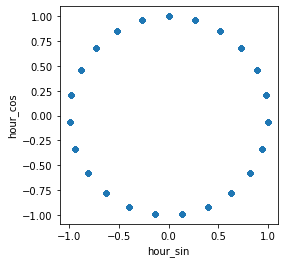

In [8]:
ax = df.plot.scatter('hour_sin', 'hour_cos').set_aspect('equal')

In [9]:
df['weekday_sin'] = np.sin(2 * np.pi * df['weekday']/6.0)
df['weekday_cos'] = np.cos(2 * np.pi * df['weekday']/6.0)

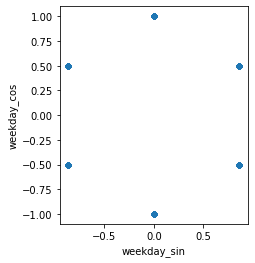

In [10]:
ax = df.plot.scatter('weekday_sin', 'weekday_cos').set_aspect('equal')

# Removing some unimportant Features

In [11]:
# import function from script
from scripts.functions import remove_columns

In [12]:
drop_list = ['ProductCategory', 'ChannelId_1', "ProductId_1", 'ProviderId_1',  'PricingStrategy_0', 'TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId',
       'CurrencyCode', 'CountryCode', 'Value', 'TransactionStartTime', 'year',
       'month', "Date", "weekday", "hour"]

df = remove_columns(df, drop_list)
df.columns

Index(['Amount', 'FraudResult', 'ProviderId_2', 'ProviderId_3', 'ProviderId_4',
       'ProviderId_5', 'ProviderId_6', 'ProductId_2', 'ProductId_3',
       'ProductId_4', 'ProductId_5', 'ProductId_6', 'ProductId_7',
       'ProductId_8', 'ProductId_9', 'ProductId_10', 'ProductId_11',
       'ProductId_12', 'ProductId_13', 'ProductId_14', 'ProductId_15',
       'ProductId_16', 'ProductId_19', 'ProductId_20', 'ProductId_21',
       'ProductId_22', 'ProductId_23', 'ProductId_24', 'ProductId_27',
       'ChannelId_2', 'ChannelId_3', 'ChannelId_5', 'PricingStrategy_1',
       'PricingStrategy_2', 'PricingStrategy_4', 'fraud_cumsum',
       'value_cumsum', 'transaction_cumsum', 'value_mean', 'hour_sin',
       'hour_cos', 'weekday_sin', 'weekday_cos'],
      dtype='object')

# Define X and y data for Modeling

In [13]:
# split data into features and targets/labels

X = df.drop("FraudResult", axis = 1)
y = df.FraudResult

In [14]:
# Train test split dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = RSEED, stratify = y)

X_train.columns

Index(['Amount', 'ProviderId_2', 'ProviderId_3', 'ProviderId_4',
       'ProviderId_5', 'ProviderId_6', 'ProductId_2', 'ProductId_3',
       'ProductId_4', 'ProductId_5', 'ProductId_6', 'ProductId_7',
       'ProductId_8', 'ProductId_9', 'ProductId_10', 'ProductId_11',
       'ProductId_12', 'ProductId_13', 'ProductId_14', 'ProductId_15',
       'ProductId_16', 'ProductId_19', 'ProductId_20', 'ProductId_21',
       'ProductId_22', 'ProductId_23', 'ProductId_24', 'ProductId_27',
       'ChannelId_2', 'ChannelId_3', 'ChannelId_5', 'PricingStrategy_1',
       'PricingStrategy_2', 'PricingStrategy_4', 'fraud_cumsum',
       'value_cumsum', 'transaction_cumsum', 'value_mean', 'hour_sin',
       'hour_cos', 'weekday_sin', 'weekday_cos'],
      dtype='object')

# Balancing the Training Dataset

In [15]:
from imblearn.over_sampling import SMOTE #require the instalation imblearn library, available in requirement.txt
from imblearn import under_sampling, over_sampling

In [16]:
def balance_traindata(X_train, y_train):
    '''
    requires 2 parameters: X_train, y_train
    returns: X_train, y_train (with balanced y_train values)
    '''
    # Oversample data
    smote_algo = SMOTE(random_state=0)
    smote_data_X, smote_data_Y = smote_algo.fit_resample(X_train, y_train)
    smote_data_X = pd.DataFrame(data=smote_data_X, columns=X_train.columns)
    smote_data_Y = pd.DataFrame(data=smote_data_Y)
    # Join X and Y smote data into one
    smote_data = smote_data_X
    return smote_data, smote_data_Y[y_test.name]

In [17]:
#from scripts.functions import balance_traindata

In [18]:
X_trainB, y_trainB = balance_traindata(X_train, y_train)

In [19]:
print(f"Shape in X_trainB =  {X_trainB.shape}")
print(f"Shape in y_trainB = {y_trainB.shape}")
print(f"Count of '0' in y_trainB = {y_trainB.value_counts()[0]}")
print(f"Count of '1' in y_trainB = {y_trainB.value_counts()[0]}")

Shape in X_trainB =  (133656, 42)
Shape in y_trainB = (133656,)
Count of '0' in y_trainB = 66828
Count of '1' in y_trainB = 66828


# SCALING DATA X_train and X_test

In [70]:
col_scale = list(X_train.columns)

In [67]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[col_scale]) #tranform the data and make the variable after standardized
X_test_scaled = scaler.transform(X_test[col_scale])

print(X_train_scaled.min())
print(X_train_scaled.max())
print(X_test_scaled.min())
print(X_test_scaled.max())
print(X_test_scaled.shape)

-9.501888138375534
220.12122402531526
-9.501888138375534
211.2305695506133
(28699, 42)


In [71]:
# Concatenating scaled and dummy columns 
X_train_preprocessed = X_train_scaled #np.concatenate([X_train_scaled, X_train.drop(col_scale, axis=1)], axis=1)
X_test_preprocessed = X_test_scaled #np.concatenate([X_test_scaled, X_test.drop(col_scale, axis=1)], axis=1)

#X_test_preprocessed.shape

In [23]:
len(X_train_preprocessed)

66963

In [24]:
len(X_test_preprocessed)

28699

# PCA 

In [72]:
pca = PCA(n_components=None)

In [73]:
s_X_train_scaled_trans = pca.fit(X_train_preprocessed)
X_train_scaled_trans = pca.transform(X_train_preprocessed)
df_X_train_scaled_trans = pd.DataFrame(X_train_scaled_trans)


In [74]:
X_test_scaled_trans = pca.transform(X_test_preprocessed)
df_X_test_scaled_trans = pd.DataFrame(X_test_scaled_trans)
#df_X_test_scaled_trans

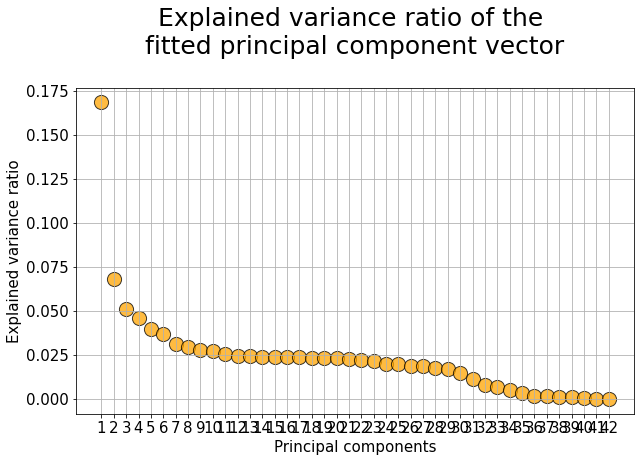

In [75]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.scatter(x=[i+1 for i in range(len(s_X_train_scaled_trans.explained_variance_ratio_))],
            y=s_X_train_scaled_trans.explained_variance_ratio_,
            s=200, alpha=0.75,c='orange',edgecolor='k')
plt.grid(True)
plt.title("Explained variance ratio of the \nfitted principal component vector\n",fontsize=25)
plt.xlabel("Principal components",fontsize=15)
plt.xticks([i+1 for i in range(len(s_X_train_scaled_trans.explained_variance_ratio_))],fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Explained variance ratio",fontsize=15)
plt.show()

# XGBoost Models with SCALED & PCA Transformed Data

In [63]:
variables = [0, 1]

[14:47:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28641
           1       0.81      0.72      0.76        58

    accuracy                           1.00     28699
   macro avg       0.90      0.86      0.88     28699
weighted avg       1.00      1.00      1.00     28699

mcc: 0.7643260943544181
acc: 0.999094045088679
Confusion matrix, without normalization
[[28631    10]
 [   16    42]]


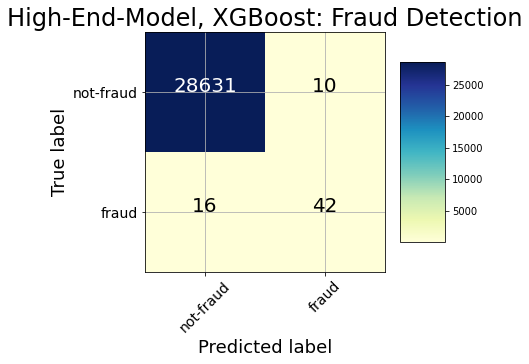

In [80]:
#f1 93%, FN 5 -- > use_label_encoder = False, n_estimators = 1000, reg_lambda = 1.5

xgb = XGBClassifier(random_state = RSEED, use_label_encoder = False, n_estimators = 1000, reg_lambda= 1.5)

xgb_model = xgb.fit(df_X_train_scaled_trans, y_train)

# Make predictions on test set 
y_pred = xgb_model.predict(df_X_test_scaled_trans)

# Evaluate your model 
cm = confusion_matrix(y_test, y_pred)

#classification Report

report = classification_report(y_test, y_pred)
print(report)

#MCC score
mcc = matthews_corrcoef(y_test, y_pred)
print(f"mcc: {mcc}")

# accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"acc: {accuracy}")


#import function from python scripts
from scripts.confusion_matrix import plot_confusion_matrix 

plt = plot_confusion_matrix(cm, classes = ['not-fraud', 'fraud'], cmap='YlGnBu', title = "High-End-Model, XGBoost: Fraud Detection")

#sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

# M3 XGBoost with Balanced Data 
## (Not Good F1/Mcc Score: 86%, with FN 5, and FP 12)

In [ ]:
#Training
xgb = XGBClassifier(use_label_encoder = False, n_estimators = 1000)
xgb_modelB = xgb.fit(X_trainB, y_trainB)

# Make predictions on test set 
y_pred = xgb.predict(X_test)

# Evaluate your model 
cm = confusion_matrix(y_test, y_pred)

#classification Report

report = classification_report(y_test, y_pred)
print(report)

#MCC score
mcc = matthews_corrcoef(y_test, y_pred)
print(f"mcc: {mcc}")

# accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"acc: {accuracy}")


#import function from python scripts
from scripts.confusion_matrix import plot_confusion_matrix 

plot_confusion_matrix(cm, classes = ['not-fraud', 'fraud'], cmap='YlGnBu', title = "High-End Model-XGBoost: Fraud Detection")
#sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

# TAKEN M3 XGBoost with Scaled Data
## The Best Score So Far (F1&MCC 93%, FN: 5 and FP: 3)

[14:48:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28641
           1       0.95      0.91      0.93        58

    accuracy                           1.00     28699
   macro avg       0.97      0.96      0.96     28699
weighted avg       1.00      1.00      1.00     28699

mcc: 0.9298286250394356
acc: 0.9997212446426704
Confusion matrix, without normalization
[[28638     3]
 [    5    53]]


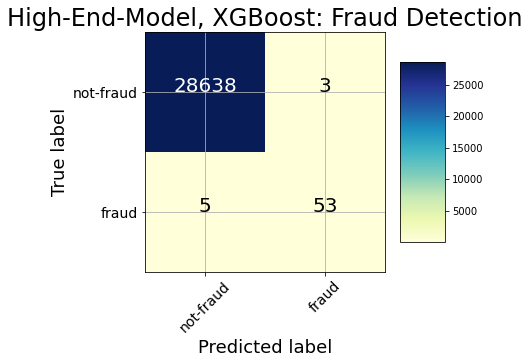

In [81]:
#f1 93%, FN 5 -- > use_label_encoder = False, n_estimators = 1000, reg_lambda = 1.5

xgb = XGBClassifier(random_state = RSEED, use_label_encoder = False, n_estimators = 1000, reg_lambda= 1.5)

xgb_model = xgb.fit(X_train_preprocessed, y_train)

# Make predictions on test set 
y_pred = xgb.predict(X_test_preprocessed)

# Evaluate your model 
cm = confusion_matrix(y_test, y_pred)

#classification Report

report = classification_report(y_test, y_pred)
print(report)

#MCC score
mcc = matthews_corrcoef(y_test, y_pred)
print(f"mcc: {mcc}")

# accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"acc: {accuracy}")


#import function from python scripts
from scripts.confusion_matrix import plot_confusion_matrix 

plt = plot_confusion_matrix(cm, classes = ['not-fraud', 'fraud'], cmap='YlGnBu', title = "High-End-Model, XGBoost: Fraud Detection")

#sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

In [26]:
# Important Features
print("Feature Importances : ", xgb_model.feature_importances_)

Feature Importances :  [2.0357101e-01 0.0000000e+00 1.1310681e-01 1.9713460e-01 2.6809091e-02
 1.5262518e-02 0.0000000e+00 1.1050226e-03 0.0000000e+00 0.0000000e+00
 2.0367412e-03 0.0000000e+00 4.6277262e-02 0.0000000e+00 3.3094887e-02
 9.3302876e-03 0.0000000e+00 3.1565387e-02 0.0000000e+00 7.4794644e-04
 0.0000000e+00 9.6528474e-03 0.0000000e+00 1.1653805e-01 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.3165140e-03 6.9847219e-03
 1.2117023e-02 0.0000000e+00 1.7300425e-02 1.6147373e-04 9.0690076e-02
 9.7094243e-03 1.0245623e-02 1.7815743e-02 3.7995677e-03 1.2205668e-02
 2.9277494e-03 7.4934578e-03]


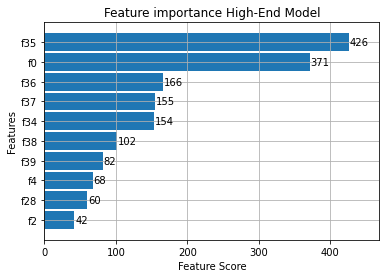

In [27]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
plot_importance(xgb_model, height=0.9, title='Feature importance High-End Model', xlabel='Feature Score', ylabel='Features', fmap='',
    importance_type='weight', max_num_features= 10,)
plt.show()

# Hyperparameter Tuning
### Notes:
* RandomizedSearchCV will work much faster than GridSearchCV, but it doesn't improve the score even make it worst. From my trial below, using RandomizedSearchCV, I end up getting only 90% f1 score and 90% recall.
* GridSearchCV works sooooo sloooowww, I have waited for hours and hours didn't come up with result.

In [ ]:
parameters = {"learning_rate" : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
              "max_depth" : [ 3, 4, 5, 6, 8, 10, 12, 15],
              "min_child_weight" : [ 1, 3, 5, 7 ],
              "gamma" : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
              "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
             "reg_lambda": [1., 1.3, 1.5, 1.7]} 



xgb = XGBClassifier(random_state= 50)

xgb_grid = RandomizedSearchCV(xgb, parameters,
                              n_jobs= -1, 
                              cv=5,
                              scoring='recall',
                              verbose=2, 
                              refit=True,
                             random_state = 50)


# training after hyperparameter tuning
model = xgb_grid.fit(X_train_preprocessed, y_train)


# Best score for hyper parameter tuning
print('Best score:', round(xgb_grid.best_score_, 3))

# Best parameters 
print('Best parameters:', xgb_grid.best_params_)

In [ ]:
#implement best_estimator_
model_best = xgb_grid.best_estimator_

# Make predictions on test set 
y_pred = model_best.predict(X_test_preprocessed)

# Evaluate your model 
cm = confusion_matrix(y_test, y_pred)

#classification Report

report = classification_report(y_test, y_pred)
print(report)

#MCC score
mcc = matthews_corrcoef(y_test, y_pred)
print(f"mcc: {mcc}")

# accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"acc: {accuracy}")


#import function from python scripts
from scripts.confusion_matrix import plot_confusion_matrix 

plot_confusion_matrix(cm, classes = ['not-fraud', 'fraud'], cmap='YlGnBu', title = "High-End-Model, XGBoost-Tuned: Fraud Detection")
#sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

## Different parameters you can play with when trying Hyperparameter Tuning

In [ ]:
"""param_dist = {'n_estimators': stats.randint(150, 500),
              'learning_rate': stats.uniform(0.01, 0.07),
              'subsample': stats.uniform(0.3, 0.7),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.45),
              'min_child_weight': [1, 2, 3]
             }
"""
"""parameters = {'objective':['binary:logistic'], #learning task and the corresponding learning objective
              'learning_rate': [0.05, 0.01, 0.1, 0.2, 0.3], #Boosting learning rate, so called `eta` value
              'max_depth': [None] + list(np.linspace(3, 20).astype(int)), #Maximum tree depth for base learners.
              'min_child_weight': [10, 11], #Minimum sum of instance weight(hessian) needed in a child
              'colsample_bytree': [0.3, 0.5, 0.7],#Subsample ratio of columns when constructing each tree
              'n_estimators': np.linspace(10, 1000).astype(int)} #number of trees, """
